<a href="https://colab.research.google.com/github/SONUXO/machine-learning/blob/main/InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D , GlobalAveragePooling2D
import itertools

In [7]:
from os import listdir
from os.path import isdir, isfile, join

In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications import InceptionV3
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [6]:
from zipfile import ZipFile
file_name= "different shapes.zip"

with ZipFile(file_name,"r") as zip:
  zip.extractall()
  print("done")

done


In [45]:
classes = sorted(listdir("/content/different shapes"))
classes

['Bevel-gear', 'fuel-tank', 'helical_gear', 'piston', 'rack-pinion', 'shocker']

In [ ]:
pip install split-folders[full]

In [10]:
import splitfolders
input_folder="different shapes"
splitfolders.ratio(input_folder, output= "dataset",seed=42,
                   ratio=(.7,.1,.2),
                   group_prefix=None)

Copying files: 100 files [00:00, 5499.21 files/s]


In [48]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen= ImageDataGenerator(rescale=1./255, shear_range=0.5,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  rotation_range=40,
                                  brightness_range=[0.1,0.9]
                                  ).flow_from_directory("/content/dataset/train",
                                                                         target_size=(244,244),
                                                                         batch_size=20,
                                                                         class_mode="categorical")
                                  
test_datagen=ImageDataGenerator(rescale=1./255).flow_from_directory("/content/dataset/test",
                                                                    target_size=(244,244),
                                                                    batch_size=20,
                                                                    class_mode="categorical",
                                                                    shuffle=False)

valid_datagen= ImageDataGenerator(rescale=1./255, shear_range=0.5,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  rotation_range=40,
                                  brightness_range=[0.1,0.9]
                                  ).flow_from_directory("/content/dataset/val",
                                                                         target_size=(244,244),
                                                                         batch_size=20,
                                                                         class_mode="categorical")     

Found 68 images belonging to 6 classes.
Found 24 images belonging to 6 classes.
Found 7 images belonging to 6 classes.


In [49]:
tf.random.set_seed(42)
In_model = InceptionV3(include_top=False,input_shape=(244, 244,3))
In_model.trainable=False
model=tf.keras.Sequential([
    In_model,
    GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    Flatten(),     
    tf.keras.layers.Dense(units=1000,activation="relu"),
    tf.keras.layers.Dense(units=6,activation="softmax")
  ]
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 1000)              2049000   
                                                                 
 dense_7 (Dense)             (None, 6)                 6006      
                                                      

In [50]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              metrics=["accuracy"]
              )

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history=model.fit(x=train_datagen, validation_data=valid_datagen,epochs=20, verbose=1 , callbacks= [tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=10, mode='min')]
                 )

In [54]:
def make_confusion_matrix(con_m, classes, normalize=False, title ="confusion matrix",cmap=plt.cm.Blues):
  plt.imshow(con_m, interpolation="nearest", cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks= np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)

  if normalize:
    con_m=con_m.astype("float")/cm.sum(axis=1)[:,np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("cofusion. matrix, without normalization")

  print(con_m)

  thresh= con_m.max()/2

  for i, j in itertools.product(range(con_m.shape[0]), range(con_m.shape[1])):
    plt.text(j,i,con_m[i,j],horizontalalignment="center",color="white" if con_m[i,j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel("True label")
  plt.xlabel("predicted label")

In [52]:
test_img,test_labels=next(test_datagen)
print(test_labels)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]]


In [55]:
predictions=model.predict(x=test_datagen,verbose=0)
results=np.round(predictions)
results

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

cofusion. matrix, without normalization
[[5 0 1 0 0 0]
 [0 5 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 0 3 0]
 [0 0 0 0 0 4]]


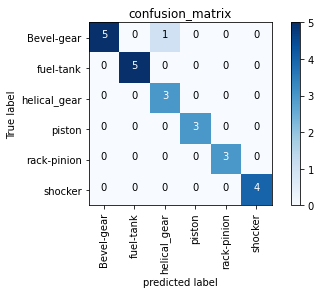

In [56]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_true=test_datagen.classes, y_pred=np.argmax(predictions, axis=-1))
make_confusion_matrix(con_m=cm,classes=classes,title="confusion_matrix")